<a href="https://colab.research.google.com/github/manjushatr/CustomerBehaviorAnalysis/blob/main/CustomerBehaviorAnalysis__Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as py
from sklearn.model_selection import GridSearchCV

**Loading the data set**


In [ ]:
customer_supermarketdf = pd.read_csv('Customer_Behaviour_df.csv', sep=',', index_col=0, decimal=',')

In [ ]:
customer_supermarketdf.shape

(642, 7)

In [ ]:
customer_supermarketdf.isnull().sum()

I            0
Iu           0
Imax         0
Entropy      0
BasketNum    0
SumExp       0
AvgExp       0
dtype: int64

**Show features' importance as bar chart.**


In [ ]:
def feature_importance(dataframe, classifier):

    importances = classifier.feature_importances_
    features = dataframe.columns

    for feat, importance in zip(features, importances):
        print('{}, importance: {:.2f}'.format(feat, importance))

    py.figure()
    py.title("Feature importances")
    py.bar(x=features, height=importances, align="center")
    py.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
import statistics
from yellowbrick.classifier import classification_report as cr, confusion_matrix as cm

def report_scores(classifier, test_pred, feat=True, conf_mat=True, report=True):

    # feature importance
    if feat:
        feature_importance(customer_supermarketdf, classifier)
        print('\n')

    # scores
    scores = cross_validate(classifier, train_set, train_label, cv=3, return_train_score= True, scoring='accuracy')

    print('Fit time ', statistics.mean(scores['fit_time']))
    print('Score time ', statistics.mean(scores['score_time']))
    print('Train score ', statistics.mean(scores['train_score']))
    print('Test score ', statistics.mean(scores['test_score']))
    print('\n')

    classes = ['high', 'low', 'medium']

    # confusion matrix
    if conf_mat:
        cm(classifier, train_set, train_label, test_set, test_label,
        classes=classes)

        py.tight_layout()


   # classification report
    if report:
        print(classification_report(test_label, test_pred))
        #cr(classifier, train_set, train_label, test_set, test_label,
          # classes=classes, support=True)

 #       plt.show()

**Defining classification labels**
After sorting the dataset by SumExp, we have splitted it in 3 equal parts.

* **First third** of customers is_low spending
* **Second third** of customers is medium spending
* **Last third** is high spending


In [ ]:
customer_supermarketdf.sort_values(by='SumExp', inplace=True)

l1 = len(customer_supermarketdf)
l2 = l1 // 3
l3 = l2*2
customer_supermarketdf['Label'] = "low"
customer_supermarketdf.loc[customer_supermarketdf.index[l2:l3], 'Label'] = "medium"
customer_supermarketdf.loc[customer_supermarketdf.index[l3:], 'Label'] = "high"

In [ ]:
customer_supermarketdf.tail()

,I,Iu,Imax,Entropy,BasketNum,SumExp,AvgExp,Label
CustomerID,,,,,,,,
15048.0,23,23,23,2.6552716097931954,1,98.7,98.7,high
13491.0,7,7,7,1.9355234866458373,1,98.9,98.9,high
17819.0,14,13,12,1.9256327515377016,2,980.12,490.06,high
15555.0,95,89,37,4.201275099410048,3,989.82,329.94,high
13418.0,33,32,22,3.30099581601381,3,992.3399999999999,330.78,high


In [ ]:
customer_supermarketdf.shape

(642, 8)

**We have dropped columns that won't be used in predictive analysis**



In [ ]:
customer_supermarketdf.drop(columns=['Iu', 'Imax', 'SumExp', 'AvgExp'], axis=1, inplace=True)

In [ ]:
customer_supermarketdf.tail()

,I,Entropy,BasketNum,Label
CustomerID,,,,
15048.0,23,2.6552716097931954,1,high
13491.0,7,1.9355234866458373,1,high
17819.0,14,1.9256327515377016,2,high
15555.0,95,4.201275099410048,3,high
13418.0,33,3.30099581601381,3,high


**Splitting Dataset**


In [ ]:
from sklearn.model_selection import train_test_split

label = customer_supermarketdf.pop("Label")
train_set, test_set, train_label, test_label = train_test_split(customer_supermarketdf, label, stratify=label, test_size=0.3, random_state=42)

train_label_cat = train_label.astype('category').cat.codes
test_label_cat = test_label.astype('category').cat.codes

print('Train set size: ', len(train_set))
print('Test set size: ', len(test_set))

Train set size:  449
Test set size:  193


**Naive Bayes classifier**

Fit time  0.004579464594523112
Score time  0.0023043950398763022
Train score  0.4064697138610182
Test score  0.40311707680835196




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


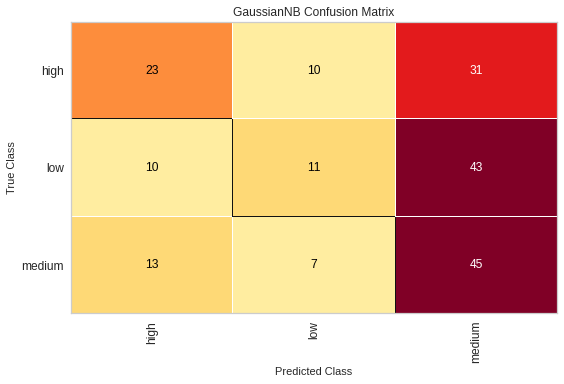

              precision    recall  f1-score   support

        high       0.50      0.36      0.42        64
         low       0.39      0.17      0.24        64
      medium       0.38      0.69      0.49        65

    accuracy                           0.41       193
   macro avg       0.42      0.41      0.38       193
weighted avg       0.42      0.41      0.38       193



<Figure size 576x396 with 0 Axes>

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(train_set, train_label)

test_pred_gnb = gnb.predict(test_set)

report_scores(gnb, test_pred_gnb, feat=False)


**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV
dt=DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5,6,7,8,9,10,15,20,30,40,50],
                  'max_features': [1, 2, 3, 4,5,6,7,8,9,10],
                 'random_state':[0, 1, 2, 3, 4, 5, 10, 15,20,35,50,80,100,150,180,200],
                 'criterion':['gini','entropy'],
                 }

grid_search = GridSearchCV(dt, param_grid = parameter_grid,
                          cv =10)

grid_search.fit(train_set, train_label)

print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))

Best Score: 0.4701515151515152
Best params: {'criterion': 'gini', 'max_depth': 2, 'max_features': 1, 'random_state': 5}


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
33600 fits failed out of a total of 48000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33600 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, n_feat

In [ ]:
dt=DecisionTreeClassifier(max_depth=2,criterion='gini',max_features=1,random_state=5)


I, importance: 0.49
Entropy, importance: 0.51
BasketNum, importance: 0.00


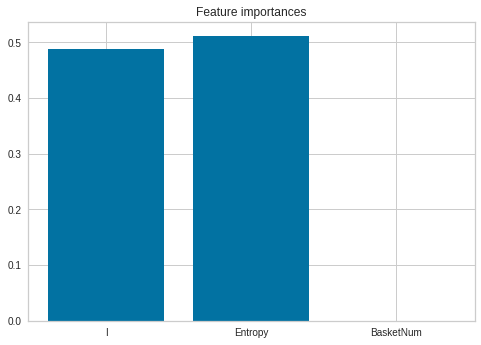



Fit time  0.0044367313385009766
Score time  0.00232545534769694
Train score  0.48777034559643256
Test score  0.45439224459358685




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


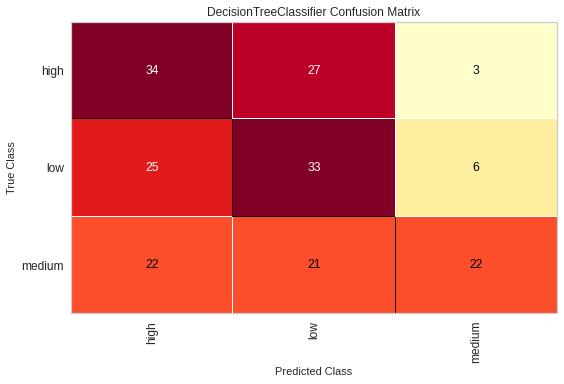

              precision    recall  f1-score   support

        high       0.42      0.53      0.47        64
         low       0.41      0.52      0.46        64
      medium       0.71      0.34      0.46        65

    accuracy                           0.46       193
   macro avg       0.51      0.46      0.46       193
weighted avg       0.51      0.46      0.46       193



<Figure size 576x396 with 0 Axes>

In [ ]:
dt.fit(train_set, train_label)
pred=dt.predict(test_set)
report_scores(dt, pred)

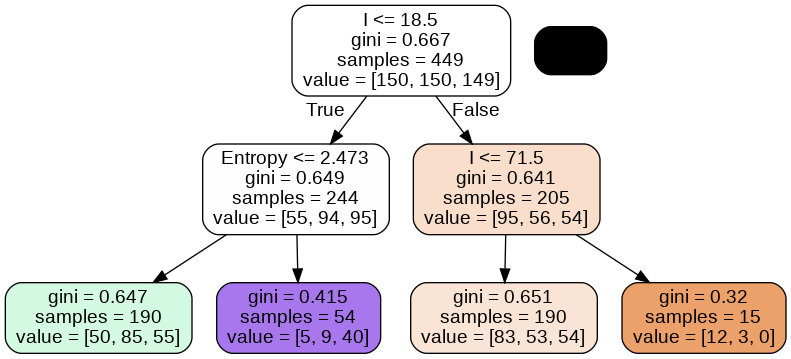

In [ ]:
# visualize the obtained decision tree
import pydotplus
from IPython.display import Image

dot_data = export_graphviz(dt, out_file=None, max_depth=3,
                           feature_names=list(train_set.columns),
                           filled=True, rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

**RandomForestClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameter_grid = {'n_estimators': [300,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,7,8,10,12],
    'criterion' :['gini', 'entropy']}
rfc = RandomForestClassifier()
grid_search = GridSearchCV(rfc, param_grid = parameter_grid,
                          cv =5)

grid_search.fit(train_set, train_label)

print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))



Best Score: 0.47220973782771536
Best params: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


I, importance: 0.39
Entropy, importance: 0.48
BasketNum, importance: 0.12


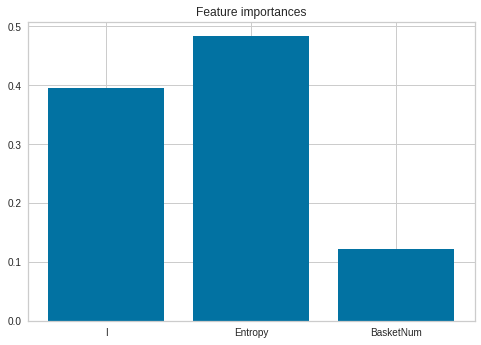



Fit time  0.773176908493042
Score time  0.06445193290710449
Train score  0.7215830546265328
Test score  0.46111856823266223




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


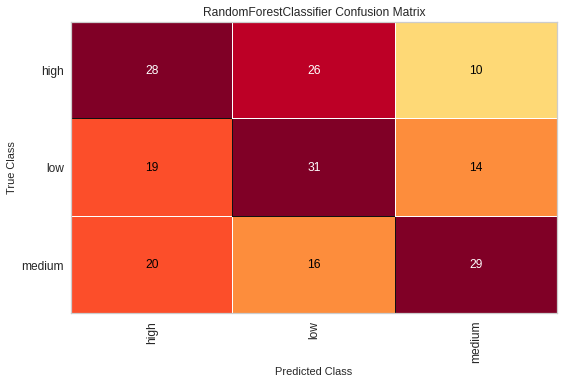

              precision    recall  f1-score   support

        high       0.42      0.44      0.43        64
         low       0.42      0.48      0.45        64
      medium       0.55      0.45      0.49        65

    accuracy                           0.46       193
   macro avg       0.46      0.46      0.46       193
weighted avg       0.46      0.46      0.46       193



<Figure size 576x396 with 0 Axes>

In [ ]:
rf=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 500, max_depth=6, criterion='entropy')

rf = rf.fit(train_set, train_label)

test_pred_rf = rf.predict(test_set)

report_scores(rf, test_pred_rf)

**KNN Classifier**

Text(0, 0.5, 'Error Rate')

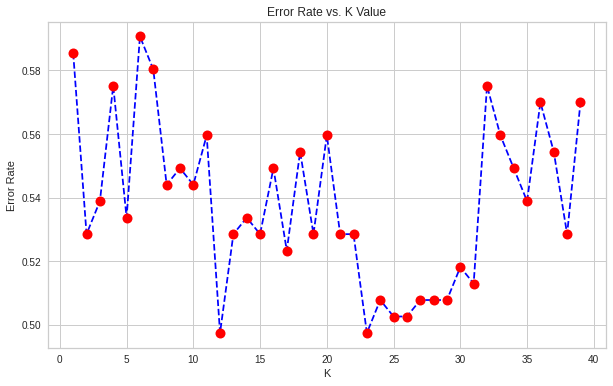

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
max_i = 40
for i in range(1,max_i):

    knn = KNeighborsClassifier(n_neighbors=i, algorithm='auto')
    knn = knn.fit(train_set, train_label)
    pred_i = knn.predict(test_set)
    error_rate.append(np.mean(pred_i != test_label))

py.figure(figsize=(10,6))
py.plot(range(1,max_i), error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
py.title('Error Rate vs. K Value')
py.xlabel('K')
py.ylabel('Error Rate')

Fit time  0.0028847853342692056
Score time  0.006753444671630859
Train score  0.5155964325529543
Test score  0.4388217747949292




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


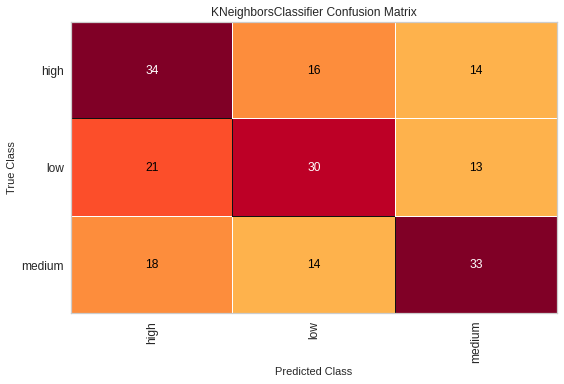

              precision    recall  f1-score   support

        high       0.47      0.53      0.50        64
         low       0.50      0.47      0.48        64
      medium       0.55      0.51      0.53        65

    accuracy                           0.50       193
   macro avg       0.51      0.50      0.50       193
weighted avg       0.51      0.50      0.50       193



<Figure size 576x396 with 0 Axes>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=12, algorithm='auto')

knn = knn.fit(train_set, train_label)

test_pred_knn = knn.predict(test_set)

report_scores(knn, test_pred_knn, feat=False)


**SVM Classifier**

Fit time  0.010041952133178711
Score time  0.004909197489420573
Train score  0.44433296172426606
Test score  0.44102908277404923




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


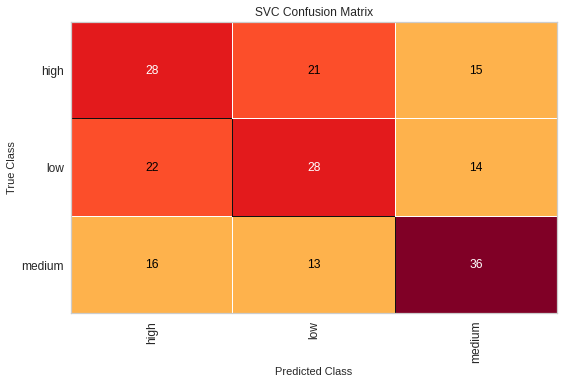

              precision    recall  f1-score   support

        high       0.42      0.44      0.43        64
         low       0.45      0.44      0.44        64
      medium       0.55      0.55      0.55        65

    accuracy                           0.48       193
   macro avg       0.48      0.48      0.48       193
weighted avg       0.48      0.48      0.48       193



<Figure size 576x396 with 0 Axes>

In [ ]:
from sklearn.svm import SVC

svm = SVC()

svm = svm.fit(train_set, train_label)

test_pred_svm = svm.predict(test_set)

report_scores(svm, test_pred_svm, feat=False)